# 1. 전처리

## 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df_man = pd.read_csv('/content/drive/MyDrive/딥러닝 final project/all_man_pulsnaver_linkconvert.csv')
df_woman = pd.read_csv('/content/drive/MyDrive/딥러닝 final project/all_woman_pulsnaver_linkconvert.csv')

In [5]:
df_man_img = df_man[['title','prd_title','prd_img','category','category_naver','prd_title_naver']]
df_woman_img = df_woman[['title','prd_title','prd_img','category','category_naver','prd_title_naver']]

#2. CNN으로 특징 추출

##2-1. VGG16
https://mapadubak.tistory.com/121 \
https://github.com/matsui528/sis \

In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
from pathlib import Path
from PIL import Image

VGG16으로 feature extract하는 class 정의

In [7]:
class FeatureExtractor:
  def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)

  def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = img
        x = np.expand_dims(x, axis=0) #차원추가
        x = preprocess_input(x) #모델에 필요한 형식에 이미지를 적절하게 맞추기위한 것
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

feature vector 추출해서 저장

In [ ]:
images_m = []
features_m_vgg = []

fe = FeatureExtractor()

for i in range(len(df_man_img)):
  img = Image.open(f"/content/drive/MyDrive/딥러닝 final project/이미지/무신사/남성/man_{i}.jpg")
  fea = fe.extract(img)
  features_m_vgg.append(fea)
  images_m.append(img)

In [9]:
images_w = []
features_w_vgg = []

fe = FeatureExtractor()

for i in range(len(df_woman_img)):
  img = Image.open(f"/content/drive/MyDrive/딥러닝 final project/이미지/무신사/여성/woman_{i}.jpg")
  fea = fe.extract(img)
  features_w_vgg.append(fea)
  images_w.append(img)

1/1 [==============================] - 1s 521ms/step


In [10]:
df_woman_img['feature_vgg'] = features_w_vgg


<ipython-input-10-5d66c09d9919>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_woman_img['feature_vgg'] = features_w_vgg


코사인 유사도 계산함수 정의

In [11]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

def cos(A, B):
  return dot(A, B)/(norm(A)*norm(B))

##2-2. Resnet18
https://becominghuman.ai/extract-a-feature-vector-for-any-image-with-pytorch-9717561d1d4c

https://daeun-computer-uneasy.tistory.com/85

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

# Image transforms
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name)
    img = img.convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros([1, 512, 1, 512])
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

pytorch로 코사인 유사도 계산함수 정의

In [13]:
def cos_pytorch(A, B):
  cos= nn.CosineSimilarity(dim=1, eps=1e-6)
  cos_sim = cos(A, B)
  return cos_sim.numpy()[0][0][0]

feature vector 추출해서 저장

In [ ]:
features_m_resnet = []
for i in range(len(df_man_img)):
  fea = get_vector(f"/content/drive/MyDrive/딥러닝 final project/이미지/무신사/남성/man_{i}.jpg")
  features_m_resnet.append(fea)

In [14]:
features_w_resnet = []
for i in range(len(df_woman_img)):
  fea = get_vector(f"/content/drive/MyDrive/딥러닝 final project/이미지/무신사/여성/woman_{i}.jpg")
  features_w_resnet.append(fea)

In [15]:
df_woman_img['feature_resnet'] = features_w_resnet

<ipython-input-15-47e409900367>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_woman_img['feature_resnet'] = features_w_resnet


#3. 신발 추천시스템 구현

## 1) 유클리디안 거리 기반 추천 (픽셀과 픽셀 간 거리)

단순거리기반

In [32]:
images_w_resize = [i.resize((224, 224)).convert('RGB') for i in images_w]

In [33]:
images_w_array = [np.array(i) for i in images_w_resize]

In [34]:
dist = []
for i in range(len(images_w_array)):
  dis= np.linalg.norm(images_w_array[0] - images_w_array[i]) #0번째 사진에 대한 추천
  dist.append((dis,i))

In [35]:
c = sorted(dist)[:9] # 상위 9개만 선택

In [36]:
print(c) #거리와 유사 아이템 인덱스

[(0.0, 0), (22172.607447027967, 315), (22780.20425720542, 637), (22892.483591781824, 159), (22979.54858129289, 319), (22998.66835275469, 204), (22998.66835275469, 221), (23011.967625563877, 237), (23074.436916206643, 494)]


In [37]:
index = [c[i][1] for i in range(len(c))]

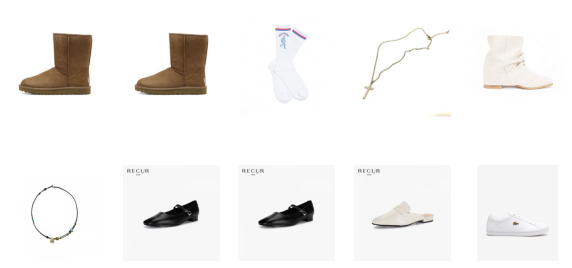

In [38]:
#추천 결과
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))

plt.subplot(2,5,1)
plt.imshow(images_w[0])
plt.axis('off')

for i in range(9):
  plt.subplot(2,5,i+2)
  plt.imshow(images_w[index[i]])
  plt.axis('off')


같은 이미지는 찾았지만 유사한 이미지는 찾지 못함

## 2) VGG16로 추출한 feature vector 간 cosine similarity 기반 추천

In [16]:
cos_dist = []
for i in range(len(df_woman_img['feature_vgg'])):
  dist= cos(df_woman_img['feature_vgg'][0],df_woman_img['feature_vgg'][i])
  cos_dist.append((dist,i))

In [17]:
b = sorted(cos_dist, reverse=True)[:9]

In [18]:
sim = [b[i][0] for i in range(len(b))]
print(sim)

[1.0, 0.8281858, 0.8065081, 0.77751416, 0.75171864, 0.744338, 0.7178459, 0.6914777, 0.6818054]


In [19]:
print(b) #resnet

[(1.0, 0), (0.8281858, 86), (0.8065081, 260), (0.77751416, 60), (0.75171864, 57), (0.744338, 54), (0.7178459, 68), (0.6914777, 340), (0.6818054, 301)]


In [20]:
index = [b[i][1] for i in range(len(b))]

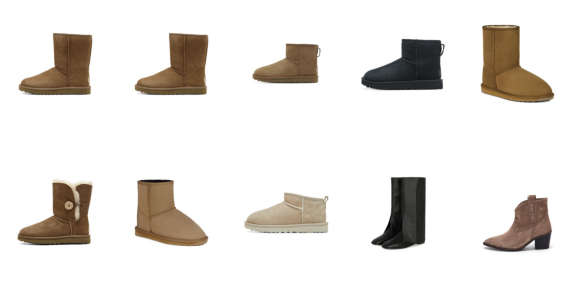

In [21]:
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))

plt.subplot(2,5,1)
plt.imshow(images_w[0])
plt.axis('off')

for i in range(9):
  plt.subplot(2,5,i+2)
  plt.imshow(images_w[index[i]])
  plt.axis('off')


## 3) Resnet18로 추출한 feature vector 간 cosine simlarity 기반 추천

In [22]:
cos_dist1 = []
for i in range(len(df_woman_img['feature_resnet'])):
  dist= cos_pytorch(df_woman_img['feature_resnet'][0],df_woman_img['feature_resnet'][i])
  cos_dist1.append((dist,i))

In [23]:
a = sorted(cos_dist1, reverse=True)[:9]

In [24]:
print(a)

[(0.9999999, 0), (0.92977726, 86), (0.91879857, 260), (0.9117464, 60), (0.896857, 57), (0.8840385, 54), (0.8762217, 68), (0.84186506, 301), (0.8358282, 358)]


In [25]:
index = [a[i][1] for i in range(len(a))]

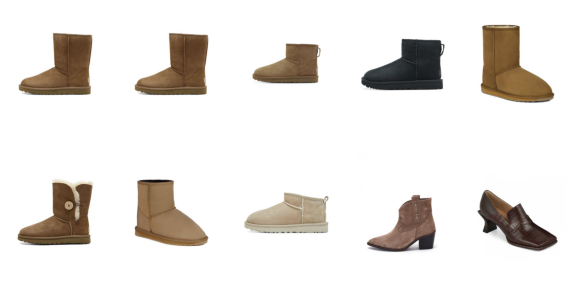

In [26]:
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))

plt.subplot(2,5,1)
plt.imshow(images_w[0])
plt.axis('off')

for i in range(9):
  plt.subplot(2,5,i+2)
  plt.imshow(images_w[index[i]])
  plt.axis('off')


## 4) Resnet19fh 추출한 feature vector 간 유클리디안 거리 기반 추천

In [27]:
dist = []
for i in range(len(df_woman_img['feature_resnet'])):
  dis= np.linalg.norm(df_woman_img['feature_resnet'][0]-df_woman_img['feature_resnet'][i])
  dist.append((dis,i))

In [28]:
d = sorted(dist)[:9]

In [29]:
print(d)

[(0.0, 0), (241.0811, 86), (269.2369, 60), (279.06485, 260), (292.41333, 57), (308.75308, 54), (329.2912, 68), (350.77094, 301), (385.01276, 122)]


In [30]:
index = [a[i][1] for i in range(len(a))]

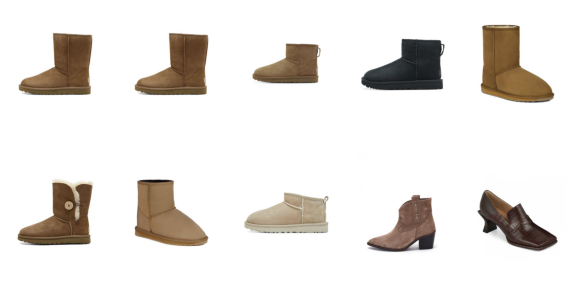

In [31]:
from matplotlib import pyplot as plt

plt.figure(figsize = (10,5))

plt.subplot(2,5,1)
plt.imshow(images_w[0])
plt.axis('off')

for i in range(9):
  plt.subplot(2,5,i+2)
  plt.imshow(images_w[index[i]])
  plt.axis('off')
